### 1. imports

In [3]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

### 2. CNN 핵심 레이어

####  A. `torch.nn.ReLU`

#### B. `torch.nn.MaxPool2d`

#### C. `torch.nn.Conv2d`


> **Note**
>
> **입력이 1장의 흑백이미지이고 출력도 1장의 흑백이미지일 경우 컨볼루션
> 계산과정 요약[1]**
>
> 1.  윈도우생성: `kernel_size` = (?,?) 인 윈도우를 만듦
> 2.  sub-img생성: 입력 이미지에 윈도우를 통과시켜 (?,?) 크기의
>     sub-img를 만듦.
> 3.  연산: sub-img의 각 원소에 `conv.weight`의 값을 원소별로
>     (=element-wisely) 곱하고 결과를 더함. (만약에 `conv.bias`가 있다면
>     최종결과에 bias를 더함)
> 4.  이동&반복: 윈도우를 `stride` 만큼 이동하여 반복. (`stride`=1
>     이라면 한칸씩, `stride`=2 라면 두칸씩 이동)

`-` (예시1) 재현

“A guide to convolution arithmetic for deep learning” (Dumoulin and
Visin 2016) 에 나온 그림재현

-   ref: <https://arxiv.org/abs/1603.07285>

<figure class="margin-caption">
<img
src="https://github.com/guebin/2021BDA/blob/master/_notebooks/2021-11-04-conv.png?raw=true"
alt="Fig: conv2d 계산과정시각화" />
<figcaption aria-hidden="true">Fig: conv2d 계산과정시각화</figcaption>
</figure>

[1] 입력shape=(1,1,?,?) 이고 출력의shape=(1,1,?,?)일 경우

In [5]:
img = torch.tensor([
    [3,3,2,1,0],
    [0,0,1,3,1],
    [3,1,2,2,3],
    [2,0,0,2,2],
    [2,0,0,0,1]
]).reshape(1,1,5,5).float()
img

tensor([[[[3., 3., 2., 1., 0.],
          [0., 0., 1., 3., 1.],
          [3., 1., 2., 2., 3.],
          [2., 0., 0., 2., 2.],
          [2., 0., 0., 0., 1.]]]])

In [6]:
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,bias=False)
conv.weight.data = torch.tensor([[[
    [ 0.0, 1.0, 2.0],
    [ 2.0, 2.0, 0.0],
    [ 0.0, 1.0, 2.0]
]]])

In [7]:
conv(img)

tensor([[[[12., 12., 17.],
          [10., 17., 19.],
          [ 9.,  6., 14.]]]], grad_fn=<ConvolutionBackward0>)

`-` (예시2) 이동평균

In [8]:
img = torch.arange(1,17).float().reshape(1,1,4,4)
img

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [9]:
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=1,bias=False)
conv.weight.data = conv.weight.data*0 + 1/4
conv.weight.data

tensor([[[[0.2500, 0.2500],
          [0.2500, 0.2500]]]])

In [10]:
conv(img)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]]]], grad_fn=<ConvolutionBackward0>)

`-` (예시3) 2개의 이미지


- 개념: (1,1,?,?) $\to$ (1,1,?,?) 의 conv를 observation 별로 적용

-   `conv` 에 포함된 파라메터 수는 (1,1,?,?) $\to$ (1,1,?,?) 인 경우와
    (n,1,?,?) $\to$ (n,1,?,?)인 경우가 동일

In [11]:
imgs = torch.arange(1,33).float().reshape(2,1,4,4)
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=1,bias=False)
conv.weight.data = conv.weight.data*0 + 1/4

In [12]:
imgs

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]],


        [[[17., 18., 19., 20.],
          [21., 22., 23., 24.],
          [25., 26., 27., 28.],
          [29., 30., 31., 32.]]]])

In [13]:
conv(imgs)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]]],


        [[[19.5000, 20.5000, 21.5000],
          [23.5000, 24.5000, 25.5000],
          [27.5000, 28.5000, 29.5000]]]], grad_fn=<ConvolutionBackward0>)

In [15]:
conv.weight.shape

torch.Size([1, 1, 2, 2])

`-` (예시4) 2개의 이미지, 2개의 out_channels

- 개념: (1,1,?,?) $\to$ (1,1,?,?) 의 conv를 한번 적용, 그것과 별개로
(1,1,?,?) $\to$ (1,1,?,?) 인 **다른** conv를 적용함. (즉 하나의
observation당 2번 conv변환) 이것을 observation별로 반복

-   (1,1,?,?) $\to$ (1,2,?,?) 인 경우는 (1,1,?,?) $\to$ (1,1,?,?)인
    경우보다 `conv`에 포함된 파라메터 수가 2배 많음
-   그런데 (1,1,?,?) $\to$ (1,2,?,?) 인 경우와 (n,1,?,?) $\to$
    (n,2,?,?)인 경우는 `conv`에 포함된 파라메터 수가 같음.
-   따라서 (n,1,?,?) $\to$ (n,2,?,?) 인 경우는 (1,1,?,?) $\to$
    (1,1,?,?)인 경우보다 `conv`에 포함된 파라메터 수가 2배 많음

In [16]:
img = torch.arange(1,33).float().reshape(2,1,4,4)
conv = torch.nn.Conv2d(in_channels=1,out_channels=2,kernel_size=2,stride=1,bias=False)

In [17]:
img

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]],


        [[[17., 18., 19., 20.],
          [21., 22., 23., 24.],
          [25., 26., 27., 28.],
          [29., 30., 31., 32.]]]])

In [18]:
conv.weight.data[0] = conv.weight.data[0]*0 +1/4
conv.weight.data[1] = conv.weight.data[0]*0

In [19]:
conv(img)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[19.5000, 20.5000, 21.5000],
          [23.5000, 24.5000, 25.5000],
          [27.5000, 28.5000, 29.5000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]]], grad_fn=<ConvolutionBackward0>)

In [20]:
conv(img)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[19.5000, 20.5000, 21.5000],
          [23.5000, 24.5000, 25.5000],
          [27.5000, 28.5000, 29.5000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]]], grad_fn=<ConvolutionBackward0>)

### 4. CNN의 학습원리

#### A. data

`-` 아래의 4개의 이미지

In [21]:
img0 = torch.tensor([
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
]).reshape(1, 1, 16, 16) 
img1 = 0.1-torch.einsum('nchw->ncwh', img0.clone())
img2 = torch.zeros((1, 1, 16, 16))
for i in range(16):
    for j in range(16):
        if j <= i:  # 대각선 아래 삼각형
            img2[0, 0, i, j] = 0.1
# 빈 이미지
img3 = torch.zeros((1, 1, 16, 16))
block_size = 2
# 블록 단위로 채우기
for i in range(0, 16, block_size):
    for j in range(0, 16, block_size):
        if ((i // block_size) + (j // block_size)) % 2 == 0:
            img3[0, 0, i:i+block_size, j:j+block_size] = 0.1

`-` `squeeze()` 차원이 1인 것을 없애줌

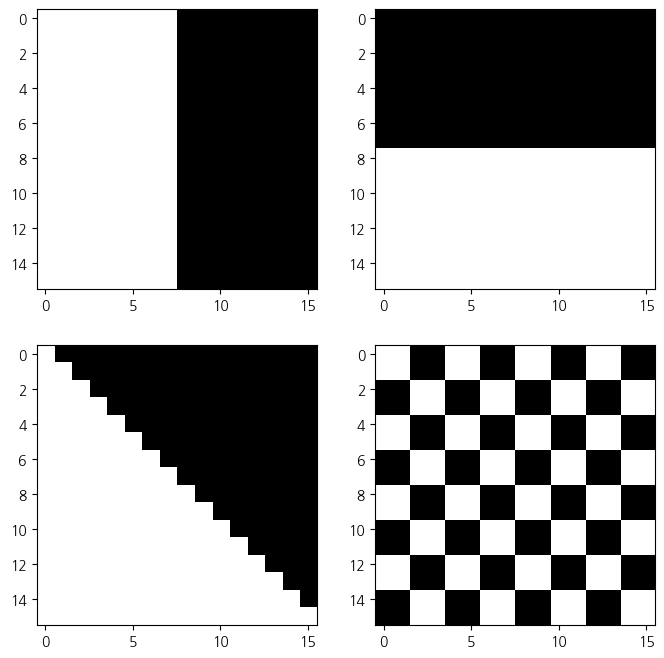

In [31]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
axs[0][0].imshow(img0.squeeze(),cmap="gray")
axs[0][1].imshow(img1.squeeze(),cmap="gray")
axs[1][0].imshow(img2.squeeze(),cmap="gray")
axs[1][1].imshow(img3.squeeze(),cmap="gray")

In [32]:
imgs = torch.concat([img0,img1,img2,img3],axis=0)
imgs.shape

torch.Size([4, 1, 16, 16])

#### B. vertical edge

In [33]:
v_conv = torch.nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    bias=False
)

In [36]:
v_conv.weight.data = torch.tensor([[[
    [ 0, 0, 0, 0],
    [ 0, 1.0, -1.0, 0],
    [0, 1.0, -1.0, 0],
    [ 0, 0, 0, 0]
]]])

`-` v_conv는 좌우방향의 펙셀 변화, 즉 수직 방향의 엣지를 감지하는데 적절

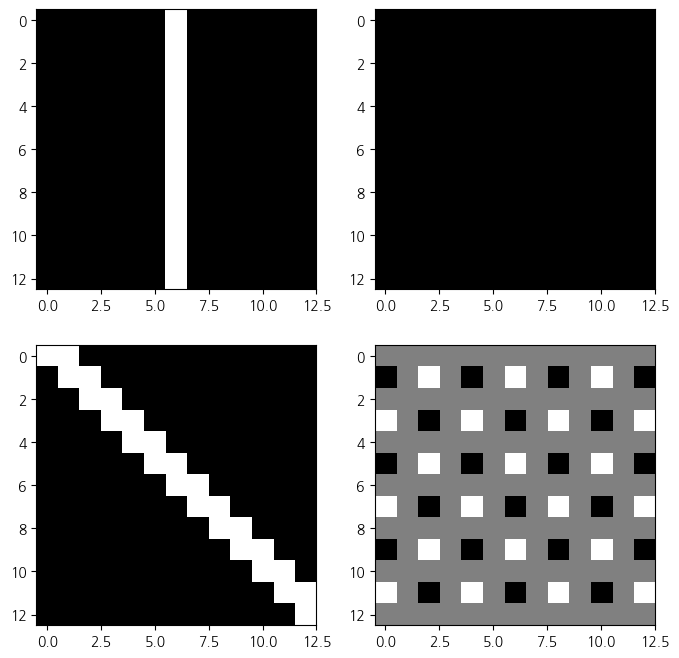

In [40]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
axs[0][0].imshow(v_conv(imgs)[0].squeeze().data,cmap="gray")
axs[0][1].imshow(v_conv(imgs)[1].squeeze().data,cmap="gray")
axs[1][0].imshow(v_conv(imgs)[2].squeeze().data,cmap="gray")
axs[1][1].imshow(v_conv(imgs)[3].squeeze().data,cmap="gray")

#### C. horizontal edge

In [38]:
h_conv = torch.nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    bias=False
)

In [39]:
h_conv.weight.data = torch.tensor([[[
    [ 0, 0, 0, 0],
    [ 0, -1.0, -1.0, 0],
    [0, 1.0, 1.0, 0],
    [ 0, 0, 0, 0]
]]])

`-` h_conv는 위아래 방향의 픽셀 변화, 즉 수평 방향의 엣지를 감지하는데 적절

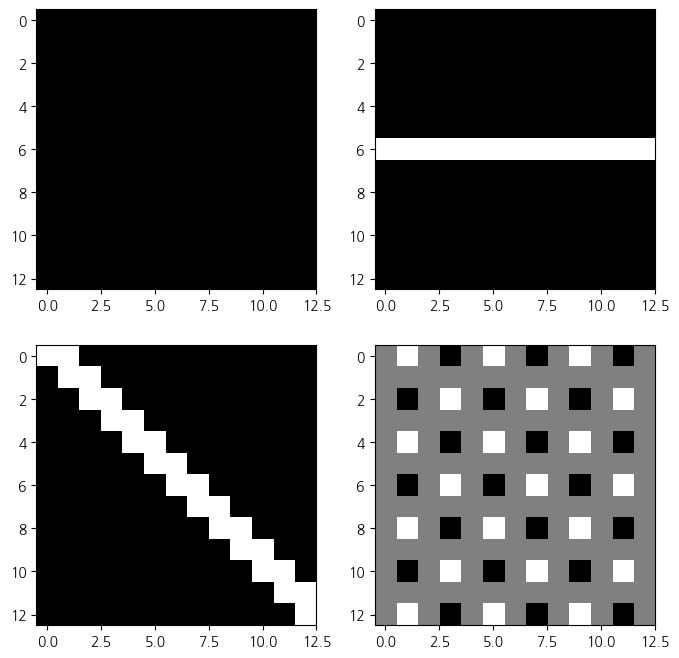

In [41]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
axs[0][0].imshow(h_conv(imgs)[0].squeeze().data,cmap="gray")
axs[0][1].imshow(h_conv(imgs)[1].squeeze().data,cmap="gray")
axs[1][0].imshow(h_conv(imgs)[2].squeeze().data,cmap="gray")
axs[1][1].imshow(h_conv(imgs)[3].squeeze().data,cmap="gray")

#### D. 이동평균

In [34]:
m_conv = torch.nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=4,
)
m_conv.weight.data = m_conv.weight.data*0 + 1/16
m_conv.bias.data = m_conv.bias.data*0 - 0.05

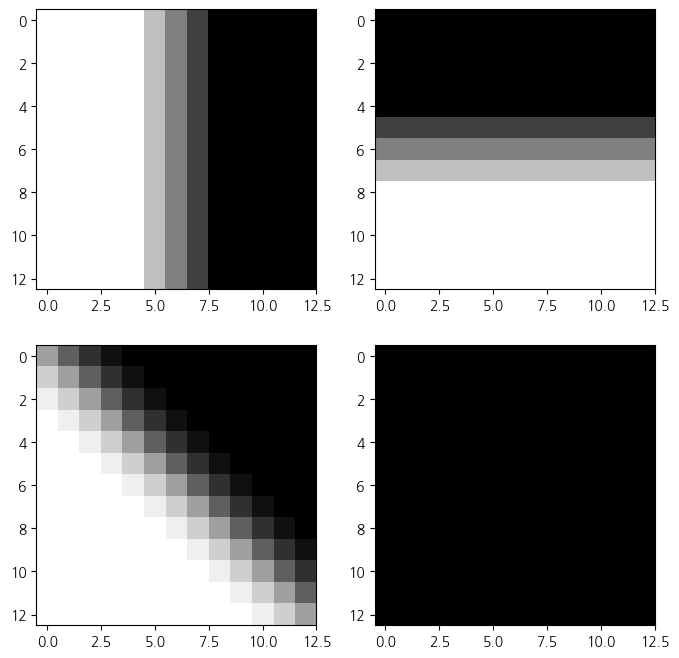

In [35]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
axs[0][0].imshow(m_conv(imgs)[0].squeeze().data,cmap="gray")
axs[0][1].imshow(m_conv(imgs)[1].squeeze().data,cmap="gray")
axs[1][0].imshow(m_conv(imgs)[2].squeeze().data,cmap="gray")
axs[1][1].imshow(m_conv(imgs)[3].squeeze().data,cmap="gray")

#### E. (C,D,E) + relu + mp

In [51]:
relu = torch.nn.ReLU()
mp = torch.nn.MaxPool2d(kernel_size=13)

In [52]:
mp(relu(v_conv(imgs)))

tensor([[[[0.2000]]],


        [[[0.0000]]],


        [[[0.1000]]],


        [[[0.2000]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

In [53]:
mp(relu(h_conv(imgs)))

tensor([[[[0.0000]]],


        [[[0.2000]]],


        [[[0.1000]]],


        [[[0.2000]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

In [54]:
mp(relu(m_conv(imgs)))

tensor([[[[5.0000e-02]]],


        [[[5.0000e-02]]],


        [[[5.0000e-02]]],


        [[[9.3132e-10]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

#### F. 구조 

In [55]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,out_channels=3,kernel_size=4),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=13),
    torch.nn.Flatten()
)
net[0].weight.data = torch.concat(
    [v_conv.weight.data,
     h_conv.weight.data,
     m_conv.weight.data],axis=0)
net[0].bias.data = torch.tensor([0.0,0.0, -0.05])

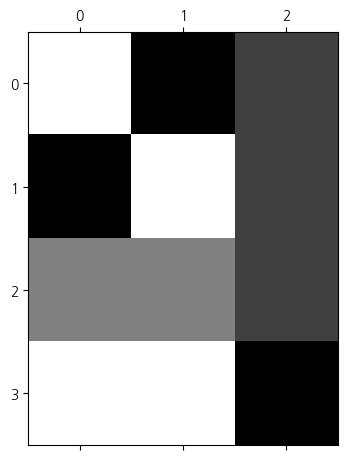

In [56]:
plt.matshow(net(imgs).data,cmap="gray")

In [57]:
net(imgs).shape

torch.Size([4, 3])

> 출력은 (n,3)으로 정리되어서 나온다. 이 시점부터는 더 이상 이미지가
> 입력이라고 생각하지 않아도 되고, 단순히 (n, 3) 크기의 숫자 데이터가
> 입력으로 주어진 것처럼 보면 된다. 즉 이제부터는 이 (n,3) 데이터를
> 입력으로 받는 신경망을 설계하면 된다.

### G. mp의 역할?

`-` 샘플이미지

In [58]:
img = torch.zeros((1, 1, 16, 16))
triangle_size = 4
for i in range(triangle_size):
    for j in range(triangle_size):
        if j <= i:  # 아래 방향 직각삼각형 (왼쪽 위 꼭짓점 기준)
            img[0, 0, i, j] = 1.0

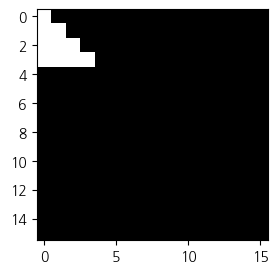

In [59]:
plt.imshow(img.squeeze(),cmap="gray")

`-` mp 1회

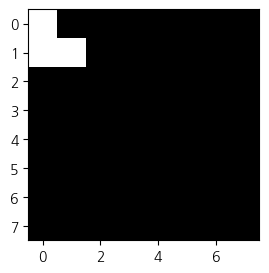

In [60]:
mp = torch.nn.MaxPool2d(kernel_size=2)
plt.imshow(mp(img).squeeze(),cmap="gray")

`-` mp 2~4회

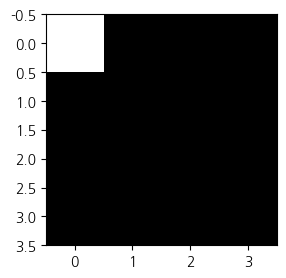

In [61]:
mp = torch.nn.MaxPool2d(kernel_size=2)
plt.imshow(mp(mp(img)).squeeze(),cmap="gray")

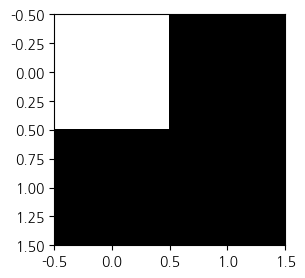

In [62]:
mp = torch.nn.MaxPool2d(kernel_size=2)
plt.imshow(mp(mp(mp(img))).squeeze(),cmap="gray")

`-` maxpooling은 이미지를 “캐리커처화” 한다고 비유할 수 있음. 디테일은
버리고, 중요한 특징만 뽑아서 과장되게 요약한다.

### 4. FashionMNIST

`-` CNN

- $\to$ 2d // flatten(conv(특징) - relu(특징추가) - maxpooling(요약))
- $\to$ 1d // 단순신경망(그냥 펼친걸로 신경망)


`-` 데이터

In [64]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=False)
train_dataset = torch.utils.data.Subset(train_dataset, range(5000))
to_tensor = torchvision.transforms.ToTensor()
X = torch.stack([to_tensor(img) for img, lbl in train_dataset]).to("cuda:0")
y = torch.tensor([lbl for img, lbl in train_dataset])
y = torch.nn.functional.one_hot(y).float().to("cuda:0")

`-` 2d를 처리하고 flatten하는 네트워크

In [70]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Flatten()
).to("cuda:0")

In [71]:
net1(X).shape

torch.Size([5000, 2304])

> 출력은 (n,2304)으로 정리되어서 나온다. 이 시점부터는 더 이상 이미지가
> 입력이라고 생각하지 않아도 되고, 단순히 (n, 2304) 크기의 숫자 데이터가
> 입력으로 주어진 것처럼 보면 된다. 즉 이제부터는 이 (n,2304) 데이터를
> 입력으로 받는 신경망을 설계하면 된다.

`-` 1d를 처리하는 네트워크

In [72]:
net2= torch.nn.Sequential(
    torch.nn.Linear(2304,10),
).to("cuda:0")

`-` 두 네트워크를 결합

In [74]:
net = torch.nn.Sequential(
    net1,
    net2
)
net(X).shape

torch.Size([5000, 10])

`-` **최종적인 코드**

In [75]:
net = torch.nn.Sequential(
    net1,
    net2
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr=torch.optim.Adam(net.parameters())
#---#
for epoc in range(100):
    #1
    netout = net(X)
    #2
    loss = loss_fn(netout,y)
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

In [76]:
(net(X).argmax(axis=1) == y.argmax(axis=1)).float().mean()

tensor(0.8806, device='cuda:0')